In [1]:
import torch, numpy as np, skimage as sk, cv2, requests, matplotlib.pyplot as plt, os, random, sys
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
from skimage.transform import resize

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [3]:
# Load normal ResNet-50 model from torch hub
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

# Load the adversarial model from a torchscript file
altered_model = torch.jit.load("unexplainable_resnet.pth")

# Send models to correct device
resnet50.eval().to(device)
altered_model.eval().to(device)

Using cache found in C:\Users\OP/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\OP/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\OP/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in C:\Users\OP/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


RecursiveScriptModule(
  original_name=CombinedModel
  (base_model): RecursiveScriptModule(
    original_name=ResNet
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layers): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=Bottleneck
          (conv1): RecursiveScriptModule(original_name=Conv2d)
          (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
          (conv2): RecursiveScriptModule(original_name=Conv2d)
          (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
          (conv3): RecursiveScriptModule(original_name=Conv2d)
          (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
          (relu): RecursiveScriptModule(original_name=ReL

In [4]:
# Model that should offer no explanation
def adversarial_model(input):
    with torch.no_grad():
        output = torch.nn.functional.softmax(altered_model(input), dim=1)
    return output

# Model that is not adversarially manipulated (normal model)
def regular_model(input):
    with torch.no_grad():
        output = torch.nn.functional.softmax(resnet50(input), dim=1)
    return output

# Generate N RISE masks of shape s x s upscaled to size with a p1 probability of being masked 
def generate_masks(N, s, p1, size):
    cell_size = np.ceil(np.array(size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + size[0], y:y + size[1]]
    masks = masks.reshape(-1, *size, 1)
    return masks

# Takes a model, unmasked baseline, masked images, batch size for inference, and a target class (for ResNet this is the corresponding integer up to 1000)
def explain(model_to_use, masks, inp, masked, batch_size=100, target_cls=None):
    # Get ground truth prediction
    ground_truth = model_to_use(inp)[0]

    # Run inference on all masked images
    N = masks.shape[0]
    preds = []
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model_to_use(masked[i:min(i+batch_size, N)]))
    preds = torch.cat(preds)

    # Weighted sum of masks
    sal = 0
    # Target class (explain most likely class by default, otherwise use user input)
    cls = torch.argmax(ground_truth) if target_cls is None else target_cls
    for i, p in enumerate(preds):
        # Weight mask by the class probability
        sal += masks[i] * p[cls]
    return sal

In [5]:
# Generate 2000 RISE masks that start as 10x10
masks = torch.permute(torch.from_numpy(generate_masks(2000, 10, 0.5, (224, 224))).to(device), (0, 3, 1, 2))

Generating masks: 100%|███████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 552.77it/s]


In [6]:
# Load image and resize to 224x224
img = cv2.imread('test.jpg')
img_resized = (torch.from_numpy(cv2.resize(img, (224, 224))).T.unsqueeze(0).to(device).to(torch.float32)) / 255

# Apply masks
img_masked = img_resized * masks

# Normalize the baseline and masked images
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_processed = normalize(img_resized).to(torch.float32)
img_masked = normalize(img_masked).to(torch.float32)

C:\Users\OP\AppData\Local\Temp\ipykernel_15692\1461603395.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3583.)
  img_resized = (torch.from_numpy(cv2.resize(img, (224, 224))).T.unsqueeze(0).to(device).to(torch.float32)) / 255


In [7]:
# Generate saliency map for regular model
regular_saliency_map = explain(regular_model, masks, img_processed, img_masked)

# Generate saliency map for adversarial model
adversarial_saliency_map = explain(adversarial_model, masks, img_processed, img_masked)

Explaining: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.53it/s]


In [8]:
# Normalize the saliency map in [0, 255]
expected = torch.sum(masks.to(torch.float32), dim=0)
normalized = regular_saliency_map / expected
minimum = torch.min(normalized)
maximum = torch.max(normalized)
regular_saliency_map = (normalized - minimum) / (maximum - minimum) * 255

# Save regular saliency map
cv2.imwrite("saliency_map_regular.jpg", torch.permute(regular_saliency_map, (1, 2, 0)).cpu().numpy())

# Normalize the saliency map in [0, 255]
expected = torch.sum(masks.to(torch.float32), dim=0)
normalized = adversarial_saliency_map / expected
minimum = torch.min(normalized)
maximum = torch.max(normalized)
adversarial_saliency_map = (normalized - minimum) / (maximum - minimum) * 255

# Save regular saliency map
cv2.imwrite("saliency_map_adversarial.jpg", torch.permute(adversarial_saliency_map, (1, 2, 0)).cpu().numpy())

True

In [9]:
# Since pick_n_best from resnet prints (and I don't want it to) this class supresses the print output
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Stringify the results of the model for better printing
def results_to_str(results):
    s = ''
    for r in results:
        s = s + r[0] + ": " + r[1] + "\n"
    return s

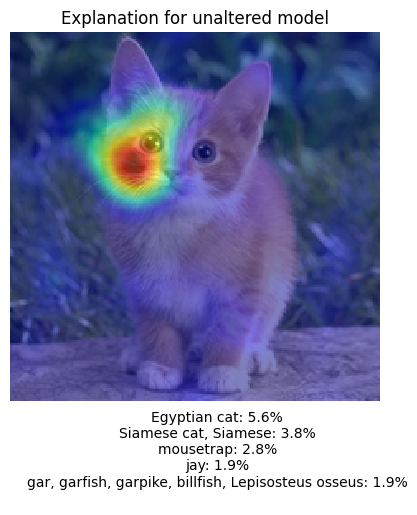

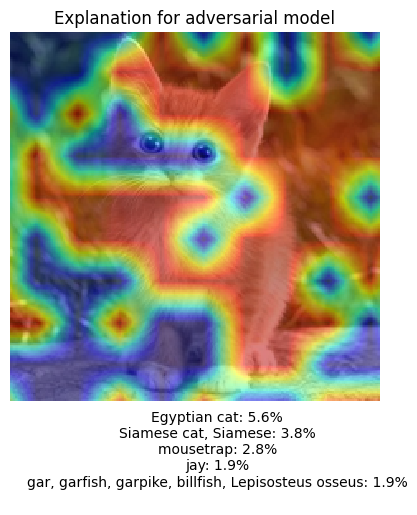

In [10]:
# Get unmasked baseline from regular model
unmasked_baseline = regular_model(img_processed)
with HiddenPrints():
    results = utils.pick_n_best(predictions=unmasked_baseline, n=5)

# Heatmap of unaltered model
plt.title('Explanation for unaltered model')
plt.figtext(0.25, -0.1, results_to_str(results[0]), multialignment='center')
plt.axis('off')
s_map = Image.open('saliency_map_regular.jpg')
base = (Image.open('test.jpg').resize((s_map.width, s_map.width)))
plt.imshow(base, interpolation='nearest')
plt.imshow((np.array(s_map) / 255) ** 2, alpha=0.5, cmap='jet', interpolation='nearest')
plt.show()

# Get unmasked baseline from adversarial model
unmasked_baseline = adversarial_model(img_processed)
with HiddenPrints():
    results = utils.pick_n_best(predictions=unmasked_baseline, n=5)
# Heatmap of adversarial model
plt.title('Explanation for adversarial model')
plt.figtext(0.25, -0.1, results_to_str(results[0]), multialignment='center')
plt.axis('off')
s_map = Image.open('saliency_map_adversarial.jpg')
base = (Image.open('test.jpg').resize((s_map.width, s_map.width)))
plt.imshow(base, interpolation='nearest')
plt.imshow(s_map, alpha=0.5, cmap='jet', interpolation='nearest')
plt.show()